# iPython Notebook Sample
### Jukka Ruponen, IBM, 2015-11-18

#### Hypothesis: "In order to get best tips, taxi drivers should favor carrying 3-4 people at once"

In order to confirm the hypothesis, this notebook will do the following:
1. Read NYC taxidata from Open API
1. Normalize and test the data
1. Perform analysis
1. (Optional) Export analysis result (as CSV file) and upload to an exteral HDFS (if you have one) for further processing
1. Visualize the result to confirm (or reject) our hypothesis

### Add the required modules

In [1]:
import pandas
import requests
import json

### Read NYC taxidata from REST API

In [2]:
raw_taxidata = requests.get('https://data.cityofnewyork.us/resource/2yzn-sicd.json')
json_taxidata = raw_taxidata.json()

In [ ]:
# Print out the data - DO NOT RUN THIS STEP unless you really want to see lots of data printed out in here!!!
json_taxidata

In [3]:
# What is the lenght of data (number of lines)?
print len(json_taxidata)

1000


### Lets normalize and test the data, and try to find an answer

In [4]:
# Lets import json_normalize since we can use it to convert JSON data to tabular data
from pandas.io.json import json_normalize

In [15]:
# Make a normalized data frame and print out the first five rows
taxidata = json_normalize(json_taxidata)
taxidata.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,extra,fare_amount,mta_tax,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2015-06-26T18:49:21.000,40.777107238769531,-73.949638366699219,1,16,0.5,1,2,2015-06-26T18:27:51.000,40.750080108642578,-73.991447448730469,1,N,0,0,17.8,3.76,2
1,2015-01-18T12:36:50.000,40.782718658447266,-73.973106384277344,0,8.5,0.5,5,2,2015-01-18T12:29:13.000,40.760688781738281,-73.9757080078125,1,N,0,0,9.3,2.28,2
2,2015-05-05T08:40:29.000,40.744693756103516,-73.980079650878906,0,7,0.5,1,2,2015-05-05T08:32:47.000,40.759136199951172,-73.970184326171875,1,N,0,0,7.8,1,1
3,2015-06-15T19:54:48.000,40.783607482910156,-73.979179382324219,1,4,0.5,1,1,2015-06-15T19:51:51.000,40.785934448242187,-73.972564697265625,1,N,1.16,0,6.96,0.5,1
4,2015-05-12T08:38:20.000,40.789329528808594,-73.952789306640625,0,12,0.5,1,1,2015-05-12T08:22:32.000,40.767032623291016,-73.953704833984375,1,N,2.56,0,15.36,2,1


In [6]:
# Since the numeric values are actually text strings, we'll first need to convert them to float
taxidata2 = taxidata.convert_objects(convert_numeric=True)

In [7]:
# Test: What is the biggest amount of fare paid?
taxidata2['fare_amount'].max()

90.0

In [8]:
# Test: What is the biggest amount of tip paid?
taxidata2['tip_amount'].max()

20.399999999999999

In [11]:
# Test: How many individual taxi trips with different number of passengers?
taxidata2['passenger_count'].value_counts()

1    689
2    140
5     77
6     43
3     38
4     13
dtype: int64

In [17]:
# Just to play around, setting index to vendorid
passengers = taxidata2.set_index(taxidata["vendor_id"])
# Drop off unneeded columns to clean the data
passengers.drop(['extra','mta_tax','vendor_id','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','rate_code','store_and_fwd_flag'], axis=1, inplace=True)
passengers.head()

,dropoff_datetime,fare_amount,passenger_count,payment_type,pickup_datetime,tip_amount,tolls_amount,total_amount,trip_distance
vendor_id,,,,,,,,,
2,2015-06-26T18:49:21.000,16.0,1,2,2015-06-26T18:27:51.000,0.00,0,17.80,3.76
2,2015-01-18T12:36:50.000,8.5,5,2,2015-01-18T12:29:13.000,0.00,0,9.30,2.28
1,2015-05-05T08:40:29.000,7.0,1,2,2015-05-05T08:32:47.000,0.00,0,7.80,1.00
1,2015-06-15T19:54:48.000,4.0,1,1,2015-06-15T19:51:51.000,1.16,0,6.96,0.50
1,2015-05-12T08:38:20.000,12.0,1,1,2015-05-12T08:22:32.000,2.56,0,15.36,2.00


In [18]:
# Test: How much tips were given total by the number of passangers in the taxi?
passengers.groupby('passenger_count')['tip_amount'].sum()

passenger_count
1                  1184.85
2                   238.05
3                    78.31
4                    27.02
5                   123.16
6                    67.02
Name: tip_amount, dtype: float64

In [19]:
# Got it! So group the data by passenger_count and extract average stats for each 'number of passengers' group
averages = passengers.groupby(['passenger_count']).agg({'fare_amount': 'mean',
                                             'tip_amount': 'mean',
                                             'trip_distance': 'mean'})
averages

,trip_distance,tip_amount,fare_amount
passenger_count,,,
1,2.941306,1.719666,12.801161
2,2.763643,1.700357,12.700000
3,3.613421,2.060789,14.947368
4,3.622308,2.078462,14.923077
5,3.140519,1.599481,12.941558
6,2.923488,1.558605,12.360465


### (Optional) Save the previous output into a CSV file in local GPFS file system

In [20]:
# Save the last result as CSV file on the local GPFS filesystem (just to make it clear: It's NOT saved in the "Object Store")
_.to_csv('NYC_taxi_passenger_tips.csv')

# Just to confirm it was saved, print out the first 4 lines of the saved file
!head -n4 'NYC_taxi_passenger_tips.csv'

passenger_count,trip_distance,tip_amount,fare_amount
1,2.941306240928882,1.7196661828737303,12.801161103047896
2,2.7636428571428597,1.7003571428571422,12.7
3,3.6134210526315798,2.060789473684211,14.947368421052632


### (Optional) Uploading the stored file into external Hadoop

In [ ]:
# Using curl, you could upload the stored file into an external HDFS (if you have one)
HDFS_WebhdfsUrl = "https://bi-hadoop-prod-2470.services.dal.bluemix.net:8443/gateway/default/webhdfs/v1" # Replace with your WebhdfsUrl
HDFS_userid = "" # WebHDFS userid
HDFS_password = "" # WebHDFS password
Local_filename = "NYC_taxi_passenger_tips.csv" # This is the local filename you used with the _.to_csv('filename') command above
HDFS_filepath = "/user/biblumix/test/test.csv" # This is the filename to be stored, with full path on HDFS (the directory will be created, if not exist)
HDFS_operator = "op=CREATE" # 'op=CREATE' will create a new file. For other operators, see: https://hadoop.apache.org/docs/r1.0.4/webhdfs.html
HDFS_maxTime = 45 # This is seconds after which the transfer will timeout, success or not. Make sure its long enough for full transfer.
!curl -i -L -k -s --user "$HDFS_userid":"$HDFS_password" --max-time $HDFS_maxTime -X PUT -T "$Local_filename" "$HDFS_WebhdfsUrl$HDFS_filepath?$HDFS_operator"

### Lets visualize the answer

In [21]:
%matplotlib inline

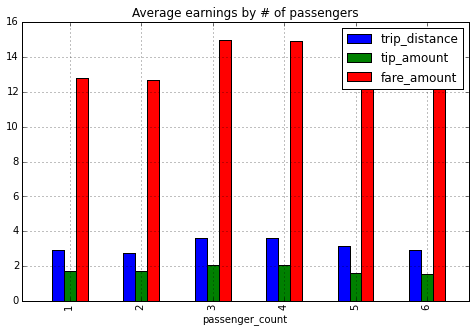

In [22]:
#passengers = averages.ix['passenger_count']
averages.plot(kind='bar', figsize=(8,5), title="Average earnings by # of passengers" % passengers)

Extra challenge: What other valuable information could you derive from the data?